# --- Day 12: Digital Plumber ---

Walking along the memory banks of the stream, you find a small village that is experiencing a little confusion: some programs can't communicate with each other.

Programs in this village communicate using a fixed system of pipes. Messages are passed between programs using these pipes, but most programs aren't connected to each other directly. Instead, programs pass messages between each other until the message reaches the intended recipient.

For some reason, though, some of these messages aren't ever reaching their intended recipient, and the programs suspect that some pipes are missing. They would like you to investigate.

You walk through the village and record the ID of each program and the IDs with which it can communicate directly (your puzzle input). Each program has one or more programs with which it can communicate, and these pipes are bidirectional; if 8 says it can communicate with 11, then 11 will say it can communicate with 8.

You need to figure out how many programs are in the group that contains program ID 0.

For example, suppose you go door-to-door like a travelling salesman and record the following list:

- 0 <-> 2
- 1 <-> 1
- 2 <-> 0, 3, 4
- 3 <-> 2, 4
- 4 <-> 2, 3, 6
- 5 <-> 6
- 6 <-> 4, 5

In this example, the following programs are in the group that contains program ID 0:

- Program 0 by definition.
- Program 2, directly connected to program 0.
- Program 3 via program 2.
- Program 4 via program 2.
- Program 5 via programs 6, then 4, then 2.
- Program 6 via programs 4, then 2.

Therefore, a total of 6 programs are in this group; all but program 1, which has a pipe that connects it to itself.

**How many programs are in the group that contains program ID 0?**

In [176]:
# the puzzle input
with open('puzzle_inputs/day12_input.txt') as f:
    data = f.read().strip().split("\n")
puzzle_input = [line for line in data]
puzzle_input[:5]

['0 <-> 46, 1376',
 '1 <-> 1465, 1889',
 '2 <-> 609, 1578',
 '3 <-> 3, 1003, 1133, 1887',
 '4 <-> 467, 1282']

First, starting with the test input from above:

In [6]:
test_input = """
0 <-> 2
1 <-> 1
2 <-> 0, 3, 4
3 <-> 2, 4
4 <-> 2, 3, 6
5 <-> 6
6 <-> 4, 5"""

test_case = [line for line in test_input.strip().split("\n")]
print("Program ID 0 connects to 6 programs in the test case")
test_case

Program ID 0 connects to 6 programs in the test case


['0 <-> 2',
 '1 <-> 1',
 '2 <-> 0, 3, 4',
 '3 <-> 2, 4',
 '4 <-> 2, 3, 6',
 '5 <-> 6',
 '6 <-> 4, 5']

First up, parse the input into a dict. A regular dict should be fine, otherwise if we are looking up non-existent programs a defaultdict works too.

In [180]:
def make_dict(programs):
    """takes an input in the form of a list of strings and returns a dictionary of
    program -> list of programs"""
    d = {}
    
    for line in programs:
        line = line.split()
        program = int(line[0])
        connects_to = [int(i) for i in "".join(line[2:]).split(",")]
        d[program] = connects_to
    return d
    
programs = make_dict(test_case)
programs

{0: [2], 1: [1], 2: [0, 3, 4], 3: [2, 4], 4: [2, 3, 6], 5: [6], 6: [4, 5]}

## easy solution with a graph library

using [networkx](https://networkx.github.io/documentation/stable/tutorial.html), since it comes up in python graph searches.

First, I make an undirected graph and add just the nodes:

In [118]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(programs.keys())
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6))

We need a list of edges in a networkx friendly format, which seems to be ideally a list of typles of edges:

In [159]:
edges = list()

for node, nodes in programs.items():
    for n in nodes:
        edges.append((node, n))

G.add_edges_from(edges)
G.edges

EdgeView([(0, 2), (1, 1), (2, 3), (2, 4), (3, 4), (4, 6), (5, 6)])

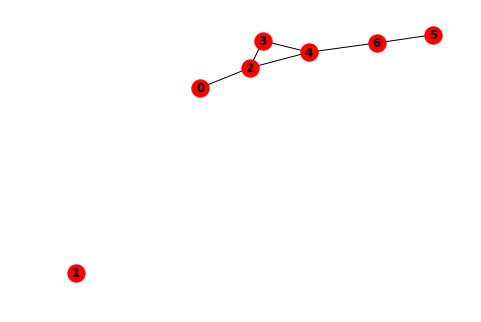

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True, font_weight='bold')

In [155]:
len(nx.node_connected_component(G, 0))

6

viola! now to make a function of the above and run it on the puzzle input:

In [164]:
def make_graph(graph_desc):
    graph_dict = make_dict(graph_desc)
    
    G = nx.Graph()
    G.add_nodes_from(graph_dict.keys())
    
    edges = list()

    for node, nodes in graph_dict.items():
        for n in nodes:
            edges.append((node, n))

    G.add_edges_from(edges)
    
    return G

G = make_graph(puzzle_input)
len(nx.node_connected_component(G, 0))

152

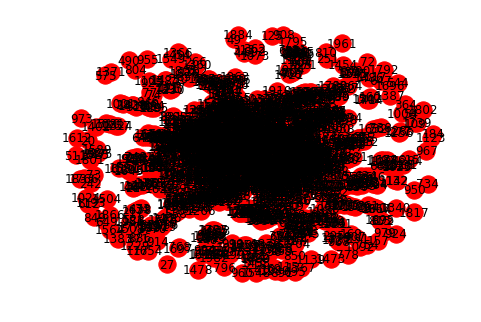

In [167]:
nx.draw(G, with_labels=True)

# --- Part Two ---

There are more programs than just the ones in the group containing program ID 0. The rest of them have no way of reaching that group, and still might have no way of reaching each other.

A group is a collection of programs that can all communicate via pipes either directly or indirectly. The programs you identified just a moment ago are all part of the same group. Now, they would like you to determine the total number of groups.

In the example above, there were 2 groups: one consisting of programs 0,2,3,4,5,6, and the other consisting solely of program 1.

**How many groups are there in total?**

Again, this is trivial with the networkx libary. [nx.connected_components](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.number_connected_components.html#networkx.algorithms.components.number_connected_components) 

In [175]:
len([c for c in sorted(nx.connected_components(G), key=len, reverse=True)])

186

## non library solution

that was pretty much cheating. Now I'm going to try to do this without using a graph library. First up, the `make_dict` function I made earlier IS a graph:

In [237]:
d = make_dict(test_case)
d

{0: [2], 1: [1], 2: [0, 3, 4], 3: [2, 4], 4: [2, 3, 6], 5: [6], 6: [4, 5]}

since its handy to have a list of nodes and edges:

In [232]:
def make_nodes_and_edges(graph_desc):
    """takes in a description and returns a list of nodes and a list of edges"""
    d = make_dict(graph_desc)
    all_nodes = list(d.keys())
    edges = set()
    
    for node, nodes in d.items():
        for n in nodes:
            edges.add((node, n))
    return all_nodes, list(edges)

nodes, edges = make_nodes_and_edges(test_case)

nodes,edges

([0, 1, 2, 3, 4, 5, 6],
 [(6, 4),
  (3, 2),
  (4, 6),
  (5, 6),
  (0, 2),
  (2, 0),
  (2, 3),
  (4, 3),
  (2, 4),
  (4, 2),
  (3, 4),
  (1, 1),
  (6, 5)])

So given a node n, how many nodes are connected to it? (including itself?)
I got stuck here, so the internet says since we have a graph we should use a bfs search

In [277]:
def connected_nodes(n, d):
    search = [n]
    ans = set()
    
    while search:
        program = search.pop()
        ans.add(program)
        for p in d[program]:
            if p not in ans and p not in search:
                search.append(p)
    return ans

d = make_dict(test_case)
connected_nodes(0, d)

{0, 2, 3, 4, 5, 6}

In [278]:
d = make_dict(puzzle_input)
len(connected_nodes(0, d))

152

Part 2 naturally follows on from part 1:

In [279]:
def sub_graphs(desc):
    d = make_dict(desc)

    sub_graphs = []

    for node in d.keys():
        sub_graph = connected_nodes(node, d)
        if sub_graph not in sub_graphs:
            sub_graphs.append(sub_graph)
    return len(sub_graphs), sub_graphs

sub_graphs(test_case)

(2, [{0, 2, 3, 4, 5, 6}, {1}])

In [280]:
sub_graphs(puzzle_input)

(186,
 [{0,
   22,
   25,
   35,
   41,
   46,
   59,
   71,
   152,
   155,
   170,
   187,
   204,
   226,
   230,
   256,
   283,
   323,
   327,
   332,
   338,
   349,
   356,
   376,
   385,
   386,
   392,
   396,
   397,
   402,
   417,
   423,
   435,
   447,
   464,
   469,
   470,
   487,
   491,
   505,
   507,
   525,
   547,
   548,
   551,
   553,
   569,
   589,
   604,
   635,
   667,
   675,
   676,
   677,
   690,
   697,
   712,
   724,
   740,
   757,
   761,
   766,
   779,
   782,
   789,
   790,
   802,
   817,
   818,
   824,
   832,
   845,
   884,
   895,
   899,
   913,
   915,
   917,
   918,
   937,
   940,
   949,
   965,
   974,
   1008,
   1012,
   1022,
   1029,
   1037,
   1061,
   1072,
   1076,
   1101,
   1104,
   1132,
   1149,
   1160,
   1176,
   1182,
   1192,
   1203,
   1221,
   1260,
   1264,
   1267,
   1281,
   1294,
   1311,
   1325,
   1332,
   1376,
   1389,
   1412,
   1461,
   1479,
   1520,
   1532,
   1550,
   1580,
   1591,
   1603

In [272]:
for a in d.keys():
    print(a)

0
1
2
3
4
5
6
